In [1]:
#@title 🔧 Runtime & Drive (optional)
USE_DRIVE = True  # toggle if you want outputs saved to Drive

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/FinSynth-Energy"
else:
    BASE_DIR = "/content"

import os, json, random, time, platform, torch
from pathlib import Path

SEED = 1298  # <- your student ID last 4 digits
random.seed(SEED); torch.manual_seed(SEED)

ASSETS_DIR = Path(BASE_DIR) / "week7_sd_assets"
OUT_DIR    = ASSETS_DIR / "outputs_sd"
LORA_DIR   = ASSETS_DIR / "lora_weights"
DATA_DIR   = ASSETS_DIR / "lora_data"  # put 10–20 SAFE images you own here

for p in (ASSETS_DIR, OUT_DIR, LORA_DIR, DATA_DIR):
    p.mkdir(parents=True, exist_ok=True)

print("CUDA available:", torch.cuda.is_available())
print("Saving to:", ASSETS_DIR.resolve())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA available: False
Saving to: /content/drive/MyDrive/FinSynth-Energy/week7_sd_assets


In [2]:
#@title ✅ Install core deps (GPU build) + env log
!pip -q install --upgrade pip
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip -q install diffusers transformers accelerate safetensors peft xformers datasets pillow

import sys, subprocess
env_info = {
    "python": sys.version,
    "platform": platform.platform(),
    "cuda_available": torch.cuda.is_available(),
    "torch": torch.__version__,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "seed": SEED
}
with open(ASSETS_DIR / "env_rag_graph.json", "w") as f:
    json.dump(env_info, f, indent=2)
env_info


{'python': '3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]',
 'platform': 'Linux-6.6.105+-x86_64-with-glibc2.35',
 'cuda_available': False,
 'torch': '2.8.0+cu126',
 'timestamp': '2025-10-13 21:04:16',
 'seed': 1298}

In [3]:
#@title 🔧 Final Working Setup (Diffusers + Transformers + Gradio harmony)
!pip uninstall -y diffusers transformers huggingface_hub accelerate safetensors peft xformers gradio > /dev/null

!pip install -U \
  diffusers==0.31.0 \
  transformers==4.45.2 \
  huggingface_hub==0.33.5 \
  accelerate==0.34.2 \
  safetensors==0.4.5 \
  peft==0.13.0 \
  xformers \
  gradio==5.49.0 -q


In [4]:
#@title ✅ Stable Diffusion 1.5 — Fully Compatible Setup
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
import torch, os

MODEL_ID = "runwayml/stable-diffusion-v1-5"
DTYPE  = torch.float16 if torch.cuda.is_available() else torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pipe_txt = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    safety_checker=None
)
pipe_img = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=DTYPE,
    safety_checker=None
)

if DEVICE == "cuda":
    pipe_txt.enable_model_cpu_offload()
    pipe_img.enable_model_cpu_offload()
    pipe_txt.to(DEVICE)
    pipe_img.to(DEVICE)

def save_image(pil_img, name):
    path = OUT_DIR / name
    pil_img.save(path)
    return str(path)

print("✅ Stable Diffusion 1.5 pipelines ready.")
print("Device:", DEVICE, "| Precision:", DTYPE)
print("Output folder:", OUT_DIR)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Stable Diffusion 1.5 pipelines ready.
Device: cpu | Precision: torch.float32
Output folder: /content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd


In [6]:
#@title ✅ txt2img: generate 3+ images (project-themed)
prompts = [
    "a clean infographic illustrating a graph-based RAG pipeline for financial analytics, teal and indigo palette, vector, minimal, high-res",
    "a professional dashboard mockup showing market signals and agent messages, flat UI, material design, subtle gradients",
    "an isometric scene of an EV factory with robots and conveyor belts, soft lighting, blueprint style, labeled components",
    "a schematic diagram: multi-hop QA over a knowledge graph, nodes and edges, numbered hops with arrows, academic poster style"
]
negative = "nsfw, low quality, blurry, watermark, text artifacts, distorted hands, extra fingers, logo"

txt2img_meta = []
for i, p in enumerate(prompts, 1):
    out = pipe_txt(
        prompt=p,
        negative_prompt=negative,
        num_inference_steps=5,
        guidance_scale=7.0,
        height=640, width=640,
        generator=torch.Generator(device=DEVICE).manual_seed(SEED+i)
    ).images[0]
    path = save_image(out, f"txt2img_{i:02d}.png")
    txt2img_meta.append({"path": path, "prompt": p})

txt2img_meta


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[{'path': '/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd/txt2img_01.png',
  'prompt': 'a clean infographic illustrating a graph-based RAG pipeline for financial analytics, teal and indigo palette, vector, minimal, high-res'},
 {'path': '/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd/txt2img_02.png',
  'prompt': 'a professional dashboard mockup showing market signals and agent messages, flat UI, material design, subtle gradients'},
 {'path': '/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd/txt2img_03.png',
  'prompt': 'an isometric scene of an EV factory with robots and conveyor belts, soft lighting, blueprint style, labeled components'},
 {'path': '/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd/txt2img_04.png',
  'prompt': 'a schematic diagram: multi-hop QA over a knowledge graph, nodes and edges, numbered hops with arrows, academic poster style'}]

In [7]:
#@title ✅ img2img: style edit (dark theme variant)
from PIL import Image

init_path = txt2img_meta[0]["path"]
init_image = Image.open(init_path).convert("RGB").resize((640, 640))

edit_prompt = "same layout but night theme with neon accents in teal and purple, high contrast, readable labels"
edited = pipe_img(
    prompt=edit_prompt,
    image=init_image,
    strength=0.55,             # 0.3 keeps more of original, 0.6 changes more
    guidance_scale=8.0,
    num_inference_steps=32,
    generator=torch.Generator(device=DEVICE).manual_seed(SEED+100)
).images[0]

edited_path = save_image(edited, "img2img_dark_variant.png")
{"init": init_path, "edited": edited_path, "prompt": edit_prompt}


  0%|          | 0/17 [00:00<?, ?it/s]

{'init': '/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd/txt2img_01.png',
 'edited': '/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd/img2img_dark_variant.png',
 'prompt': 'same layout but night theme with neon accents in teal and purple, high contrast, readable labels'}

In [ ]:
#@title ✅ inpaint (optional quick patch)
from diffusers import StableDiffusionInpaintPipeline
import numpy as np-

pipe_inp = StableDiffusionInpaintPipeline.from_pretrained(
    MODEL_ID, torch_dtype=DTYPE, safety_checker=None
)
if DEVICE == "cuda":
    pipe_inp.enable_attention_slicing()
    pipe_inp.to(DEVICE)

base = Image.open(txt2img_meta[1]["path"]).convert("RGB").resize((640,640))

# simple rectangular mask (white=paint area)
mask = Image.new("L", (640,640), 0)
mx, my, mw, mh = 60, 520, 520, 70
for x in range(mx, mx+mw):
    for y in range(my, my+mh):
        mask.putpixel((x,y), 255)

inpaint_prompt = "insert a clean rounded banner labeled 'FinSynth-Energy' with subtle glow, consistent with the UI"
inp = pipe_inp(
    prompt=inpaint_prompt,
    image=base,
    mask_image=mask,
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=torch.Generator(device=DEVICE).manual_seed(SEED+200)
).images[0]

inpaint_path = save_image(inp, "inpaint_banner.png")
{"inpainted": inpaint_path}


In [8]:
#@title ✅ LoRA training scaffold (prepare config & CLI)
rag_graph_run_config = {
    "model": MODEL_ID,
    "data_dir": str(DATA_DIR),
    "output_dir": str(LORA_DIR),
    "batch_size": 1,
    "grad_accum": 4,
    "lr": 1e-4,
    "max_steps": 800,   # 600–1200 typical for a tiny concept
    "precision": "fp16"
}
with open(ASSETS_DIR / "rag_graph_run_config.json", "w") as f:
    json.dump(rag_graph_run_config, f, indent=2)

print("➡️ Put 10–20 SAFE images you own into:", DATA_DIR.resolve())
print("\nRun this once your data is ready:")
print(f"""
!accelerate launch \\
  diffusers/examples/text_to_image/train_text_to_image_lora.py \\
  --pretrained_model_name_or_path="{MODEL_ID}" \\
  --instance_data_dir="{DATA_DIR}" \\
  --output_dir="{LORA_DIR}" \\
  --train_batch_size={rag_graph_run_config['batch_size']} \\
  --gradient_accumulation_steps={rag_graph_run_config['grad_accum']} \\
  --learning_rate={rag_graph_run_config['lr']} \\
  --max_train_steps={rag_graph_run_config['max_steps']} \\
  --mixed_precision="{rag_graph_run_config['precision']}"
""")


➡️ Put 10–20 SAFE images you own into: /content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/lora_data

Run this once your data is ready:

!accelerate launch \
  diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --instance_data_dir="/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/lora_data" \
  --output_dir="/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/lora_weights" \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=0.0001 \
  --max_train_steps=800 \
  --mixed_precision="fp16"



In [9]:
#@title ✅ Apply LoRA weights (after training) and export 2+ images
# Uncomment after you’ve trained
# pipe_txt.load_lora_weights(str(LORA_DIR))
# lora_prompts = [
#     "FinSynth-Energy style infographic: agent messages flowing into a knowledge graph, teal/indigo, crisp labels",
#     "EV factory overview in FinSynth-Energy LoRA style, soft blueprint lines, callouts for 'RAG', 'QA', 'Agent'"
# ]
# lora_out = []
# for i,p in enumerate(lora_prompts, 1):
#     img = pipe_txt(
#         prompt=p,
#         negative_prompt="nsfw, low quality, watermark",
#         num_inference_steps=26,
#         guidance_scale=7.0,
#         height=640, width=640,
#         generator=torch.Generator(device=DEVICE).manual_seed(SEED+300+i)
#     ).images[0]
#     lora_out.append(save_image(img, f"lora_out_{i:02d}.png"))
# lora_out
print("ℹ️ When LoRA is trained, uncomment the block above to generate LoRA-stylized assets.")


ℹ️ When LoRA is trained, uncomment the block above to generate LoRA-stylized assets.


In [10]:
#@title ✅ Export CSV + simple gallery manifest
from glob import glob
import pandas as pd

rows = []
for p in sorted(glob(str(OUT_DIR / "*.png"))):
    name = Path(p).name
    if name.startswith("txt2img"):
        variant = "txt2img"
    elif name.startswith("img2img"):
        variant = "img2img"
    elif name.startswith("inpaint"):
        variant = "inpaint"
    elif name.startswith("lora_out"):
        variant = "lora"
    else:
        variant = "other"
    rows.append({"file": name, "variant": variant, "seed": SEED})

ablation = pd.DataFrame(rows)
csv_path = ASSETS_DIR / "ablation_results_graph.csv"
ablation.to_csv(csv_path, index=False)

manifest = {
    "base_dir": str(OUT_DIR),
    "images": [Path(r["file"]).as_posix() for _, r in ablation.iterrows()]
}
with open(ASSETS_DIR / "gallery_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

csv_path, ASSETS_DIR / "gallery_manifest.json"


(PosixPath('/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/ablation_results_graph.csv'),
 PosixPath('/content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/gallery_manifest.json'))

📁 Loaded images from: /content/drive/MyDrive/FinSynth-Energy/week7_sd_assets/outputs_sd
🖼️ Total images: 5


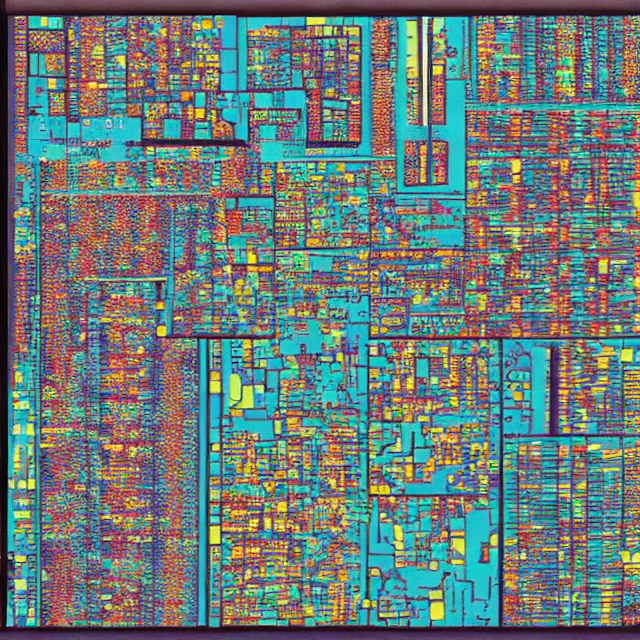

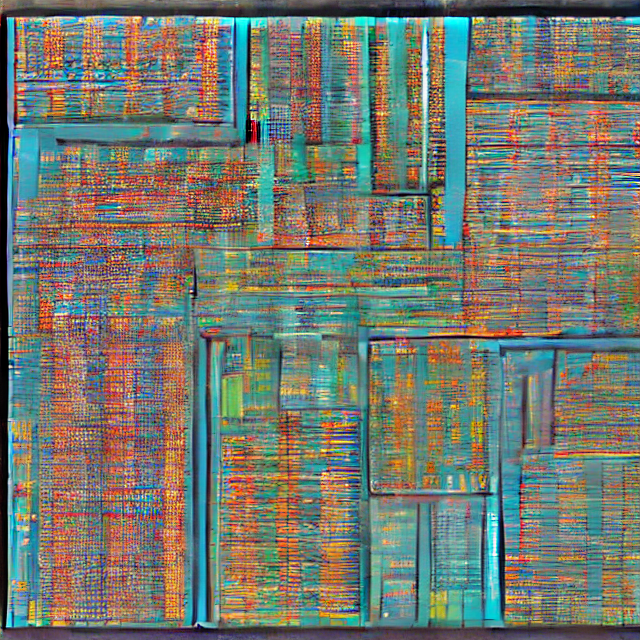

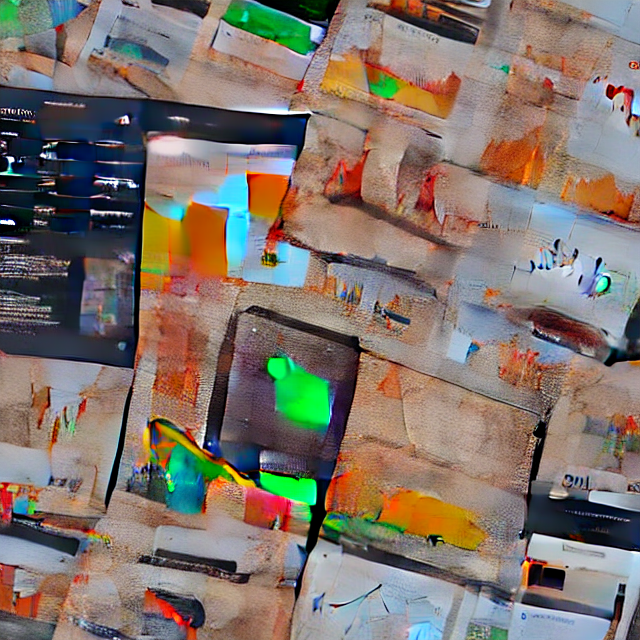

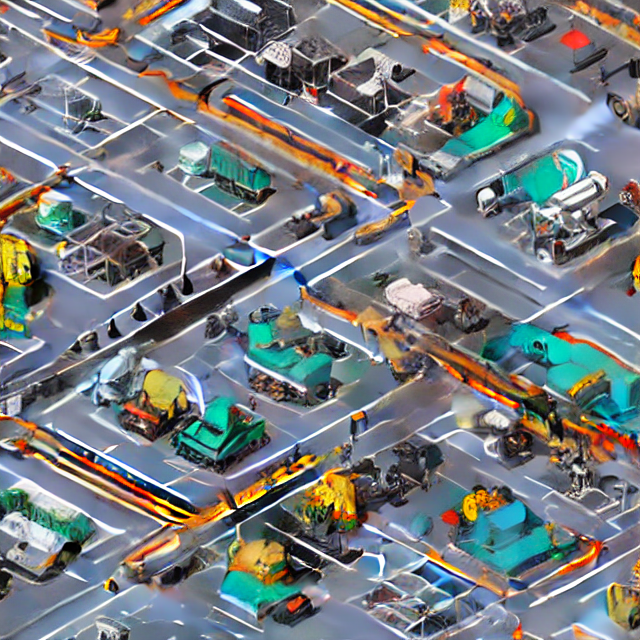

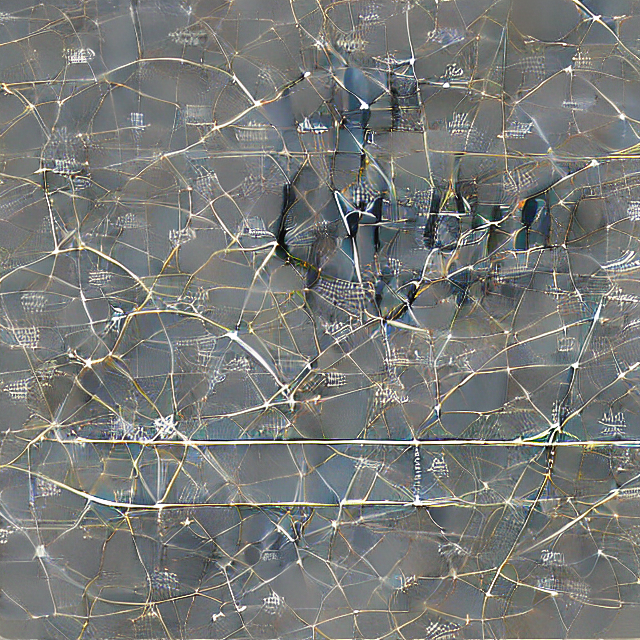

In [11]:
#@title 🖼️ View all generated images from Track A
from IPython.display import display, Image
from pathlib import Path
import json, os

# Load gallery manifest
with open(ASSETS_DIR / "gallery_manifest.json") as f:
    gallery = json.load(f)

print("📁 Loaded images from:", gallery["base_dir"])
print("🖼️ Total images:", len(gallery["images"]))

# Display each image (resize for notebook view)
for img_name in gallery["images"]:
    img_path = os.path.join(gallery["base_dir"], img_name)
    display(Image(filename=img_path, width=350))
